In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

import neuro_morpho_toolbox as nmt
# ns=nmt.neuron_set('/Users/pengxie/Documents/Research/fullMorph_classification/data/registered_swc/Janelia_test/swc/Whole/')
ns=nmt.neuron_set('/home/penglab/Documents/Janelia_1000')



/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.97
Loading CCF brain structure data...
Loading time: 0.01
Loading...
100 loaded: 2.5s
Invalid number of soma found: 0
QC failed: AA0114.swc
Invalid number of soma found: 0
QC failed: AA0115.swc
200 loaded: 1.9s
300 loaded: 2.3s
400 loaded: 2.3s
Invalid number of soma found: 0
QC failed: AA0472.swc
500 loaded: 2.4s
Invalid number of soma found: 0
QC failed: AA0576.swc
Invalid number of soma found: 0
QC failed: AA0585.swc
Invalid number of soma found: 0
QC failed: AA0589.swc
600 loaded: 2.3s
Invalid number of soma found: 0
QC failed: AA0639.swc
Invalid number of soma found: 0
QC failed: AA0670.swc
Invalid number of soma found: 0
QC failed: AA0672.swc
700 loaded: 2.2s
Invalid number of soma found: 0
QC failed: AA0754.swc
Invalid number of soma found: 0
QC failed: AA0763.swc
800 loaded: 2.6s
900 loaded: 1.8s
QC failed: AA0952.swc
QC failed: AA0964.swc
QC failed: AA0968.swc
QC

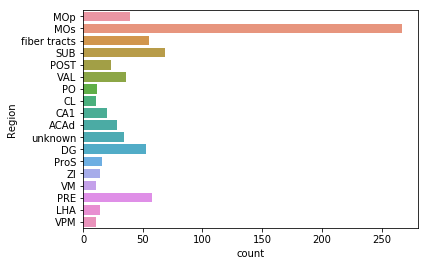

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)


## Initialization for each cluster 

In [4]:
colname = ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient','parameter']
#method=['SNN_community','Kmeans'
#%% Store all the result
result_COMP = pd.DataFrame(columns = colname)

## For hierarchy

#%% Store the result of Hierarchy
result_hier = pd.DataFrame(columns = colname)
L_method_list=['single', 'complete','average','weighted','centroid','median','ward']
L_metric_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
               'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
               'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
               'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
#linkage using 'yule' and 'jensenshannon' may result in a condensed distance matrix must contain only finite values.

criterionH_list=['inconsistent','distance','maxclust','monocrit','maxclust_monocrit']

hier_dict={'L_method':'single', 'L_metric':'euclidean','criterionH':'inconsistent', 'depth':2,'R':None,'t':0.9,'optimal_ordering':False}
for L_methodidx in L_method_list:
    hier_dict.update(L_method = L_methodidx)
    for L_metricidx in L_metric_list:
        hier_dict.update(L_metric = L_metricidx )
        for criterionidx in criterionH_list:
            hier_dict.update(criterionH = criterionidx )   
            for depth_iter in range(2,15):
                hier_dict.update(depth = depth_iter ) 
                print(hier_dict)
                _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
                if len(typeR)<2:
                    SS = 'below'
                elif len(typeR)>=ns.UMAP.shape[0]:
                    SS = 'above'
                else:
                    SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
                tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(hier_dict)]).T.copy()
                tempDF.columns=colname
                result_hier = result_hier.append(tempDF)    
idx_hier = ['Hier'+str(x) for x in range(result_hier.shape[0])]    
result_hier['idx'] = idx_hier
result_hier.set_index('idx',inplace=True)    

In [12]:
#result_hier.to_excel('/home/penglab/Documents/dataSource/result_hier.xlsx')
result_hier = pd.read_excel('/home/penglab/Documents/dataSource/result_hier.xlsx', index_col=0)

## For KMeans


from sklearn import metrics
colname = ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient','parameter']
#method=['SNN_community','Kmeans'
result_kmeans = pd.DataFrame(columns = colname)

init_list=['k-means++','random']
algorithm_list = ['auto','full','elkan']
precompute_distances_list = ['auto', True, False]
n_init_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
               'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
               'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
               'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
#linkage using 'yule' and 'jensenshannon' may result in a condensed distance matrix must contain only finite values.

criterionH_list='inconsistent','distance','maxclust','monocrit','maxclust_monocrit'

kmeans_dict={'n_clusters':20, 'init':'k-means++', 'n_init':10, 'max_iter':300, 'tol':0.0001,'precompute_distances':'auto', 'verbose':0, 'random_state':None,'copy_x': True,'n_jobs':None, 'algorithm':'auto'}

for init_idx in init_list:
    kmeans_dict.update(init = init_idx)
    for algorithm_idx in algorithm_list:
        kmeans_dict.update(algorithm = algorithm_idx )
        for precompute_distances_idx in precompute_distances_list:
            kmeans_dict.update(precompute_distances = precompute_distances_idx )
            for n_clustersidx in range(3,25):
                kmeans_dict.update(n_clusters = n_clustersidx)     
                #Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
                for n_initidx in range(7,25):
                    kmeans_dict.update(n_init = n_initidx) 
                    print(kmeans_dict)
                    _ = ns. get_clusters(method='Kmeans',karg_dict=kmeans_dict)
                    h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
                    if len(typeR)<2:
                        SS = 'below'
                    elif len(typeR)>=ns.UMAP.shape[0]:
                        SS = 'above'
                    else:
                        SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
                    
                    tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(kmeans_dict)]).T.copy()
                    tempDF.columns=colname
                    result_kmeans = result_kmeans.append(tempDF)         
idx_kmeans = ['KMeans'+str(x) for x in range(result_kmeans.shape[0])]    
result_kmeans['idx'] = idx_kmeans
result_kmeans.set_index('idx',inplace=True)       

In [11]:
#result_kmeans.to_excel('/home/penglab/Documents/dataSource/result_kmeans.xlsx')
result_kmeans = pd.read_excel('/home/penglab/Documents/dataSource/result_kmeans.xlsx', index_col=0)

## for DBSCAN


result_dbscan = pd.DataFrame(columns = colname)
algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']
dbscan_dict={'eps':20, 'min_samples':5, 'metric':'euclidean','metric_params':None, 'algorithm':'auto', 'leaf_size':30, 'p':None,'n_jobs':None}
for algorithm_idx in algorithm_list:
    dbscan_dict.update(algorithm = algorithm_idx )
    for epsidx in np.arange(0,1,0.005)[1:]:
        dbscan_dict.update(eps = epsidx)
        #print(result_dbscan )
        _ = ns. get_clusters(method='DBSCAN',karg_dict=dbscan_dict)
        h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
        if len(typeR)<2:
            SS = 'below'
        elif len(typeR)>=ns.UMAP.shape[0]:
            SS = 'above'
        else:
            SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
        tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(dbscan_dict)]).T.copy()
        tempDF.columns=colname
        result_dbscan = result_dbscan.append(tempDF)        
idx_dbscan = ['DBSCAN'+str(x) for x in range(result_dbscan.shape[0])]    
result_dbscan['idx'] = idx_dbscan
result_dbscan.set_index('idx',inplace=True)       

In [10]:
#result_dbscan.to_excel('/home/penglab/Documents/dataSource/result_dbscan.xlsx')
result_dbscan = pd.read_excel('/home/penglab/Documents/dataSource/result_dbscan.xlsx', index_col=0)

## for HDBSCAN


In [ ]:
result_hdbscan = pd.DataFrame(columns = colname)
from sklearn.neighbors.ball_tree import BallTree
metric_list = ['euclidean', 'manhattan', 'cityblock', 'l1', 'chebyshev','l2', 'minkowski']
#, 'p', 'seuclidean', 
              # 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 
             #  'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener','sokalsneath', 'haversine', 'pyfunc']
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan','braycurtis',
              # 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 
             #  'kulsinski', 'mahalanobis', 'matching', 'minkowski','rogerstanimoto', 
              # 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
#check use of 'boruvka_balltree' for algorithm later
algorithm_list = ['best', 'generic','prims_kdtree', 'boruvka_kdtree']#, 
cluster_selection_method_list = ['leaf','eom']
hdbscan_dict={'min_cluster_size':5, 'metric':'euclidean','alpha':1.0, 'min_samples':1,
              'p':2,'algorithm':'best', 'leaf_size':40, 'approx_min_span_tree':True,
              'gen_min_span_tree':False,'core_dist_n_jobs':4,'cluster_selection_method':'eom',
              'allow_single_cluster': False,'prediction_data':False,
              'match_reference_implementation':False}

for algorithm_idx in algorithm_list:
    hdbscan_dict.update(algorithm = algorithm_idx)
    for metric_idx in metric_list:
        hdbscan_dict.update(metric = metric_idx)
        for cluster_selection_method_idx in cluster_selection_method_list:
            hdbscan_dict.update(cluster_selection_method = cluster_selection_method_idx )
            for alpha_idx in np.arange(0.8,1.5,0.1):
                hdbscan_dict.update(alpha = alpha_idx)
                for min_samples_iter in range(1,10):
                    hdbscan_dict.update(min_samples = min_samples_iter)
            
                    #print(hdbscan_dict)
                    _ = ns. get_clusters(method='HDBSCAN',karg_dict=hdbscan_dict)
                    h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
                    if len(typeR)<2:
                        SS = 'below'
                    elif len(typeR)>=ns.UMAP.shape[0]:
                        SS = 'above'
                    else:
                        SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
                    print(hdbscan_dict)
                    tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(hdbscan_dict)]).T.copy()
                    tempDF.columns = colname
                    result_hdbscan = result_hdbscan.append(tempDF)     
                    
idx_hdbscan = ['HDBSCAN'+str(x) for x in range(result_hdbscan.shape[0])]    
result_hdbscan['idx'] = idx_hdbscan
result_hdbscan.set_index('idx',inplace=True)       



In [6]:
result_hdbscan.to_excel('/home/penglab/Documents/dataSource/result_hdbscan.xlsx')
result_hdbscan = pd.read_excel('/home/penglab/Documents/dataSource/result_hdbscan.xlsx', index_col=0)

## Pre-process the data
* result_hier      9100 x 7
* result_kmeans    7128 x 7
* result_dbscan    796  x 7
* result_hdbscan   3528  x 7

## Plot each kind of clustering result separately

each line corresponds to one column



In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_col(dflocal,cluster_name,dropF):
    #result_hier_self=result_hier.copy()
    if dropF:
        df = dflocal.iloc[:,:-1].drop_duplicates()
    else:
        df = dflocal.copy()
    df = df[df['Silhouette Coefficient']!='below'].copy()
    df = df[df['Silhouette Coefficient']!='above'].copy()
    col_Homogeneity = df['Homogeneity']
    col_Completeness = df['Completeness']
    col_Vmeasure= df['V-measure']
    col_ARI = df['Adjusted Rand Index']
    col_AMI = df['Adjusted Mutual Information']
    col_SC = df['Silhouette Coefficient']
    
    x_axix=range(1,df.shape[0]+1)

    plt.title('Value fluctuation for '+str(cluster_name)+'with '+str(df.shape[0])+' unique trials')
    plt.plot(x_axix, col_Homogeneity.tolist(), color='green', label='Homogeneity')
    plt.plot(x_axix, col_Completeness.tolist(), color='brown', label='Completeness')
    plt.plot(x_axix, col_Vmeasure.tolist(),  color='skyblue', label='V-measure')
    plt.plot(x_axix, col_ARI.tolist(), color='blue', label='Adjusted Rand Index')
    plt.plot(x_axix, col_AMI.tolist(), color='magenta', label='Adjusted Mutual Information')
    plt.plot(x_axix, col_SC.tolist(), color='pink', label='Silhouette Coefficient')
    plt.legend() # 显示图例
    #a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    #plt.xticks(arange(len(a)),a)
    plt.xlabel('Different Parameter Choices')
    plt.ylabel('metric')
    plt.show()

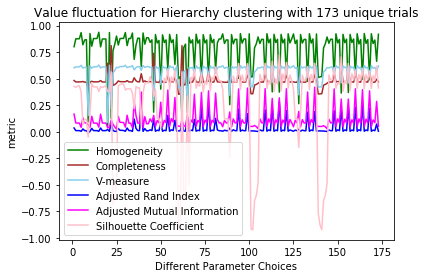

/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



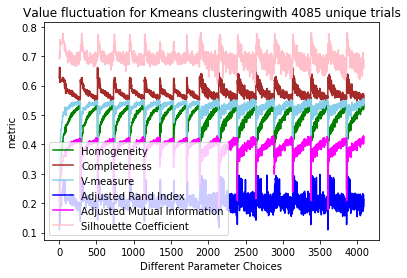

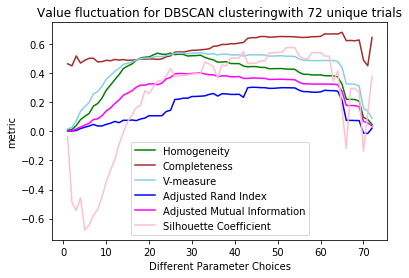

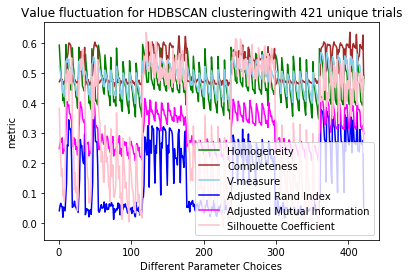

In [14]:
plot_col(result_hier.copy(),'Hierarchy clustering ',1)
plot_col(result_kmeans.copy(),'Kmeans clustering',1)
plot_col(result_dbscan.copy(),'DBSCAN clustering',1)
plot_col(result_hdbscan.copy(),'HDBSCAN clustering',1)

# To compare all the results for different metirc
### Detail
* metric can be 'Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient'
* Delete clustering result leading to cluster less than 2 or # of cluster = # of swc files

### Add SNN

In [15]:
result_snn= pd.DataFrame(columns = colname)
_ = ns. get_clusters(method='SNN_community')
h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
if len(typeR)<2:
    SS = 'below'
elif len(typeR)>=ns.UMAP.shape[0]:
    SS = 'above'
else:
    SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,'default']).T.copy()
tempDF.columns=colname
result_snn = result_snn.append(tempDF)

Result of SNN_community


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [16]:
import numpy as np
import ast
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
def compare_bestmetric(strname):
    result_COMP = pd.DataFrame(columns =['method','parameter','num_Cluster'],index=['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'])
    #if strname=='Silhouette Coefficient':
    scresult_hier = result_hier.copy()
    scresult_kmeans = result_kmeans.copy()
    scresult_dbscan = result_dbscan.copy()
    scresult_hdbscan = result_hdbscan.copy()
    scresult_snn = result_snn.copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='below'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='below'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='below'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='below'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='below'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='above'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='above'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='above'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='above'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='above'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Completeness']!=1].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Completeness']!=1].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Completeness']!=1].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Completeness']!=1].copy()
    scresult_snn = scresult_snn[scresult_snn['Completeness']!=1].copy()
    row_hier = scresult_hier[scresult_hier[strname]==scresult_hier[strname].max()].iloc[0,:]
    row_kmeans = scresult_kmeans[scresult_kmeans[strname]==scresult_kmeans[strname].max()].iloc[0,:]
    row_dbscan = scresult_dbscan[scresult_dbscan[strname]==scresult_dbscan[strname].max()].iloc[0,:]
    row_hdbscan = scresult_hdbscan[scresult_hdbscan[strname]==scresult_hdbscan[strname].max()].iloc[0,:]
    row_snn = scresult_snn[scresult_snn[strname]==scresult_snn[strname].max()].iloc[0,:]
    '''
    else:        
        row_hier = result_hier[result_hier[strname]==np.max(result_hier[strname])].iloc[0,:]
        row_kmeans = result_kmeans[result_kmeans[strname]==np.max(result_kmeans[strname])].iloc[0,:]
        row_dbscan = result_dbscan[result_dbscan[strname]==np.max(result_dbscan[strname])].iloc[0,:]
        row_hdbscan = result_hdbscan[result_hdbscan[strname]==np.max(result_hdbscan[strname])].iloc[0,:]
    '''
    x_axix=range(1,len(colname))
    
    
    hier_dict=row_hier['parameter']
    result_COMP.loc['Hierarchy']['parameter'] = (hier_dict)
    _ = ns. get_clusters(method='Hierarchy',karg_dict=ast.literal_eval(hier_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Hierarchy is '+str(hier_dict))
    result_COMP.loc['Hierarchy']['num_Cluster']=len(typeR)
    
    kmeans_dict=row_kmeans['parameter']
    result_COMP.loc['Kmeans']['parameter'] = kmeans_dict
    _ = ns. get_clusters(method='Kmeans',karg_dict=ast.literal_eval(kmeans_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Kmeans is '+str(kmeans_dict))
    result_COMP.loc['Kmeans']['num_Cluster']=len(typeR)
    
    dbscan_dict=row_dbscan['parameter']
    result_COMP.loc['DBSCAN']['parameter'] = dbscan_dict
    _ = ns. get_clusters(method='DBSCAN',karg_dict=ast.literal_eval(dbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using DBSCAN is '+str(dbscan_dict))
    result_COMP.loc['DBSCAN']['num_Cluster']=len(typeR)
    
    hdbscan_dict=row_hdbscan['parameter']
    result_COMP.loc['HDBSCAN']['parameter'] = hdbscan_dict
    _ = ns. get_clusters(method='HDBSCAN',karg_dict=ast.literal_eval(hdbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_COMP.loc['HDBSCAN']['num_Cluster']=len(typeR)
    
    #snn_dict=row_snn['parameter']
    result_COMP.loc['SNN']['parameter'] = 'default'
    _ = ns. get_clusters(method='SNN')
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_COMP.loc['SNN']['num_Cluster']=len(typeR)    
    
    plt.title('Result Analysis w.r.t. highest '+str(strname))
    plt.plot(x_axix, row_hier.tolist()[:-1], color='green', label='Hierarchy clustering')
    plt.plot(x_axix, row_kmeans.tolist()[:-1], color='red', label='KMeans clustering')
    plt.plot(x_axix, row_dbscan.tolist()[:-1],  color='skyblue', label='DBSCAN clustering')
    plt.plot(x_axix, row_hdbscan.tolist()[:-1], color='blue', label='HDBSCAN clustering')
    plt.plot(x_axix, row_snn.tolist()[:-1], color='brown', label='SNN clustering')
    plt.legend() # 显示图例
    a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    plt.xticks(arange(len(a)),a)
    plt.ylabel('metric')
    plt.show()
    result_COMP['method']=result_COMP.index
    #print(result_COMP)
    return result_COMP
    

/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


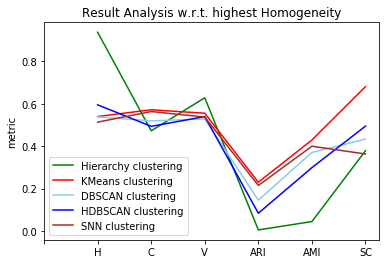

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",709
Kmeans,Kmeans,"{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",24
DBSCAN,DBSCAN,"{'eps': 0.155, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",41
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 1, 'p': 2, 'algorithm': 'best', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False...",74
SNN,SNN,default,74


{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}
{'eps': 0.155, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 1, 'p': 2, 'algorithm': 'best', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
default
Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



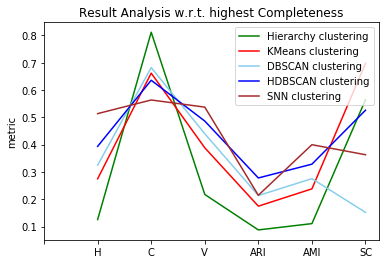

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",2
Kmeans,Kmeans,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
DBSCAN,DBSCAN,"{'eps': 0.49, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",8
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 1.2, 'min_samples': 9, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",10
SNN,SNN,default,10


{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}
{'eps': 0.49, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 1.2, 'min_samples': 9, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
default
Result of Hierarchy CLustering
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of DBSCAN
Result of HDBSCAN


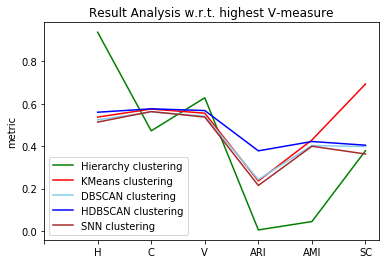

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",709
Kmeans,Kmeans,"{'n_clusters': 23, 'init': 'random', 'n_init': 20, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",23
DBSCAN,DBSCAN,"{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",28
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",46
SNN,SNN,default,46


{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 23, 'init': 'random', 'n_init': 20, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}
{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
default
Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



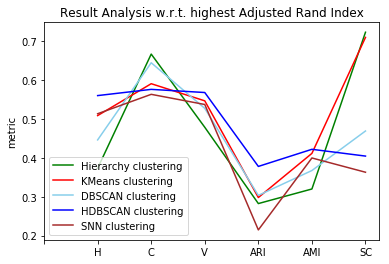

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",7
Kmeans,Kmeans,"{'n_clusters': 19, 'init': 'random', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",19
DBSCAN,DBSCAN,"{'eps': 0.25, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",17
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",46
SNN,SNN,default,46


{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 19, 'init': 'random', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}
{'eps': 0.25, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
default
Result of Hierarchy CLustering
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of DBSCAN
Result of HDBSCAN


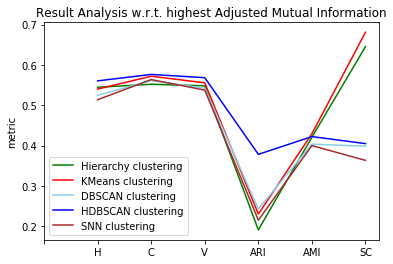

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",33
Kmeans,Kmeans,"{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",24
DBSCAN,DBSCAN,"{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",28
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",46
SNN,SNN,default,46


{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}
{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
default
Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



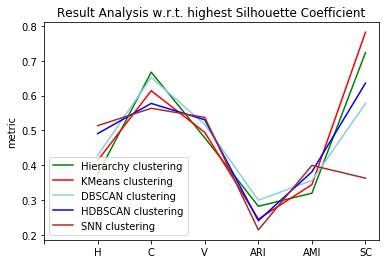

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",7
Kmeans,Kmeans,"{'n_clusters': 10, 'init': 'random', 'n_init': 17, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",10
DBSCAN,DBSCAN,"{'eps': 0.33, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",12
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 6, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",27
SNN,SNN,default,27


{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 10, 'init': 'random', 'n_init': 17, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}
{'eps': 0.33, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 6, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
default


In [19]:
from IPython.display import display
#'Homogeneity','Completeness','V-measure' did not result in satisfying result
metriclist= ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']

for metric_iter in metriclist:
    bestDF = compare_bestmetric(metric_iter)
    pd.set_option('max_colwidth',300)
    display(bestDF)
    for i in bestDF['parameter']:
        print(i)

# Best average among V, ARI, AMI and SC

In [83]:
colname

['Homogeneity',
 'Completeness',
 'V-measure',
 'Adjusted Rand Index',
 'Adjusted Mutual Information',
 'Silhouette Coefficient',
 'parameter']

In [20]:
import numpy as np
import ast
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
def compare_bestavg():
    strname='avg'
    result_avg = pd.DataFrame(columns =['method','parameter','num_Cluster','avg'],index=['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'])
    #if strname=='Silhouette Coefficient':
    scresult_hier = result_hier.copy()
    scresult_kmeans = result_kmeans.copy()
    scresult_dbscan = result_dbscan.copy()
    scresult_hdbscan = result_hdbscan.copy()
    scresult_snn = result_snn.copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='below'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='below'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='below'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='below'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='below'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='above'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='above'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='above'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='above'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='above'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Completeness']!=1].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Completeness']!=1].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Completeness']!=1].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Completeness']!=1].copy()
    scresult_snn = scresult_snn[scresult_snn['Completeness']!=1].copy()
 
    scresult_hier['avg']=scresult_hier[['V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_kmeans['avg']=scresult_kmeans[['V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_dbscan['avg']=scresult_dbscan[['V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_hdbscan['avg']=scresult_hdbscan[['V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_snn['avg']=scresult_snn[['V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    
    row_hier = scresult_hier[scresult_hier[strname]==scresult_hier[strname].max()].iloc[0,:]
    row_kmeans = scresult_kmeans[scresult_kmeans[strname]==scresult_kmeans[strname].max()].iloc[0,:]
    row_dbscan = scresult_dbscan[scresult_dbscan[strname]==scresult_dbscan[strname].max()].iloc[0,:]
    row_hdbscan = scresult_hdbscan[scresult_hdbscan[strname]==scresult_hdbscan[strname].max()].iloc[0,:]
    row_snn = scresult_snn[scresult_snn[strname]==scresult_snn[strname].max()].iloc[0,:]

    x_axix=range(1,len(colname))
    
    
    hier_dict=row_hier['parameter']
    result_avg.loc['Hierarchy']['parameter'] = (hier_dict)
    result_avg.loc['Hierarchy']['avg'] = row_hier['avg']
    _ = ns. get_clusters(method='Hierarchy',karg_dict=ast.literal_eval(hier_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Hierarchy is '+str(hier_dict))
    result_avg.loc['Hierarchy']['num_Cluster']=len(typeR)
    
    kmeans_dict=row_kmeans['parameter']
    result_avg.loc['Kmeans']['parameter'] = kmeans_dict
    result_avg.loc['Kmeans']['avg'] = row_kmeans['avg']
    _ = ns. get_clusters(method='Kmeans',karg_dict=ast.literal_eval(kmeans_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Kmeans is '+str(kmeans_dict))
    result_avg.loc['Kmeans']['num_Cluster']=len(typeR)
    
    dbscan_dict=row_dbscan['parameter']
    result_avg.loc['DBSCAN']['parameter'] = dbscan_dict
    result_avg.loc['DBSCAN']['avg'] = row_dbscan['avg']
    _ = ns. get_clusters(method='DBSCAN',karg_dict=ast.literal_eval(dbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using DBSCAN is '+str(dbscan_dict))
    result_avg.loc['DBSCAN']['num_Cluster']=len(typeR)
    
    hdbscan_dict=row_hdbscan['parameter']
    result_avg.loc['HDBSCAN']['parameter'] = hdbscan_dict
    result_avg.loc['HDBSCAN']['avg'] = row_hdbscan['avg']
    _ = ns. get_clusters(method='HDBSCAN',karg_dict=ast.literal_eval(hdbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_avg.loc['HDBSCAN']['num_Cluster']=len(typeR)
    
    #snn_dict=row_snn['parameter']
    result_avg.loc['SNN']['parameter'] = 'default'
    result_avg.loc['SNN']['avg'] = row_snn['avg']
    _ = ns. get_clusters(method='SNN')
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_avg.loc['SNN']['num_Cluster']=len(typeR)    
    
    plt.title('Result Analysis w.r.t. highest avg value among v,ARI, AMI and SC')
    plt.plot(x_axix, row_hier.tolist()[:-2], color='green', label='Hierarchy clustering')
    plt.plot(x_axix, row_kmeans.tolist()[:-2], color='red', label='KMeans clustering')
    plt.plot(x_axix, row_dbscan.tolist()[:-2],  color='skyblue', label='DBSCAN clustering')
    plt.plot(x_axix, row_hdbscan.tolist()[:-2], color='blue', label='HDBSCAN clustering')
    plt.plot(x_axix, row_snn.tolist()[:-2], color='brown', label='SNN clustering')
    plt.legend() # 显示图例
    a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    plt.xticks(arange(len(a)),a)
    plt.ylabel('metric')
    plt.show()
    result_avg['method']=result_avg.index
    #print(result_COMP)
    return result_avg
    

/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


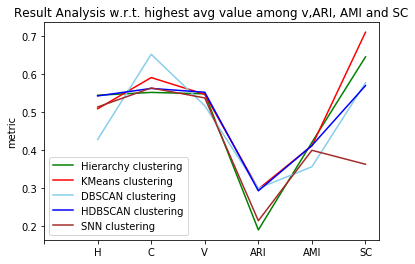

,method,parameter,num_Cluster,avg
Hierarchy,Hierarchy,"{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",33,0.451158
Kmeans,Kmeans,"{'n_clusters': 19, 'init': 'random', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",19,0.491628
DBSCAN,DBSCAN,"{'eps': 0.33, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",12,0.437657
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'manhattan', 'alpha': 0.8, 'min_samples': 4, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",38,0.456944
SNN,SNN,default,38,0.378774


In [21]:
compare_bestavg()

# Look into the soma intra-cluster and inter-cluster distance

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
def soma_intraD(uniqueDF,cluster_name,dropF):
    #result_hier_self=result_hier.copy()
    if dropF:
        df = dflocal.iloc[:,:-1].drop_duplicates()
    else:
        df = dflocal.copy()
    df = df[df['Silhouette Coefficient']!='below'].copy()
    df = df[df['Silhouette Coefficient']!='above'].copy()
    df = df[df['Completeness']!=1].copy()
    
    row_hier = scresult_hier[scresult_hier[strname]==scresult_hier[strname].max()].iloc[0,:]
    
    
    col_Homogeneity = df['Homogeneity']
    col_Completeness = df['Completeness']
    col_Vmeasure= df['V-measure']
    col_ARI = df['Adjusted Rand Index']
    col_AMI = df['Adjusted Mutual Information']
    col_SC = df['Silhouette Coefficient']
    
    x_axix=range(1,df.shape[0]+1)

    plt.title('Value fluctuation for '+str(cluster_name)+'with '+str(df.shape[0])+' unique trials')
    plt.plot(x_axix, col_Homogeneity.tolist(), color='green', label='Homogeneity')
    plt.plot(x_axix, col_Completeness.tolist(), color='brown', label='Completeness')
    plt.plot(x_axix, col_Vmeasure.tolist(),  color='skyblue', label='V-measure')
    plt.plot(x_axix, col_ARI.tolist(), color='blue', label='Adjusted Rand Index')
    plt.plot(x_axix, col_AMI.tolist(), color='magenta', label='Adjusted Mutual Information')
    plt.plot(x_axix, col_SC.tolist(), color='pink', label='Silhouette Coefficient')
    plt.legend() # 显示图例
    #a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    #plt.xticks(arange(len(a)),a)
    plt.xlabel('Different Parameter Choices')
    plt.ylabel('metric')
    plt.show()
    
    
import numpy as np
import ast
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
def compare_bestmetric(strname):
    result_COMP = pd.DataFrame(columns =['method','parameter','num_Cluster'],index=['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'])
    #if strname=='Silhouette Coefficient':
    scresult_hier = result_hier.copy()
    scresult_kmeans = result_kmeans.copy()
    scresult_dbscan = result_dbscan.copy()
    scresult_hdbscan = result_hdbscan.copy()
    scresult_snn = result_snn.copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='below'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='below'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='below'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='below'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='below'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='above'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='above'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='above'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='above'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='above'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Completeness']!=1].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Completeness']!=1].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Completeness']!=1].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Completeness']!=1].copy()
    scresult_snn = scresult_snn[scresult_snn['Completeness']!=1].copy()
    row_hier = scresult_hier[scresult_hier[strname]==scresult_hier[strname].max()].iloc[0,:]
    row_kmeans = scresult_kmeans[scresult_kmeans[strname]==scresult_kmeans[strname].max()].iloc[0,:]
    row_dbscan = scresult_dbscan[scresult_dbscan[strname]==scresult_dbscan[strname].max()].iloc[0,:]
    row_hdbscan = scresult_hdbscan[scresult_hdbscan[strname]==scresult_hdbscan[strname].max()].iloc[0,:]
    row_snn = scresult_snn[scresult_snn[strname]==scresult_snn[strname].max()].iloc[0,:]
    '''
    else:        
        row_hier = result_hier[result_hier[strname]==np.max(result_hier[strname])].iloc[0,:]
        row_kmeans = result_kmeans[result_kmeans[strname]==np.max(result_kmeans[strname])].iloc[0,:]
        row_dbscan = result_dbscan[result_dbscan[strname]==np.max(result_dbscan[strname])].iloc[0,:]
        row_hdbscan = result_hdbscan[result_hdbscan[strname]==np.max(result_hdbscan[strname])].iloc[0,:]
    '''
    x_axix=range(1,len(colname))
    
    
    hier_dict=row_hier['parameter']
    result_COMP.loc['Hierarchy']['parameter'] = (hier_dict)
    _ = ns. get_clusters(method='Hierarchy',karg_dict=ast.literal_eval(hier_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Hierarchy is '+str(hier_dict))
    result_COMP.loc['Hierarchy']['num_Cluster']=len(typeR)
    
    kmeans_dict=row_kmeans['parameter']
    result_COMP.loc['Kmeans']['parameter'] = kmeans_dict
    _ = ns. get_clusters(method='Kmeans',karg_dict=ast.literal_eval(kmeans_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Kmeans is '+str(kmeans_dict))
    result_COMP.loc['Kmeans']['num_Cluster']=len(typeR)
    
    dbscan_dict=row_dbscan['parameter']
    result_COMP.loc['DBSCAN']['parameter'] = dbscan_dict
    _ = ns. get_clusters(method='DBSCAN',karg_dict=ast.literal_eval(dbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using DBSCAN is '+str(dbscan_dict))
    result_COMP.loc['DBSCAN']['num_Cluster']=len(typeR)
    
    hdbscan_dict=row_hdbscan['parameter']
    result_COMP.loc['HDBSCAN']['parameter'] = hdbscan_dict
    _ = ns. get_clusters(method='HDBSCAN',karg_dict=ast.literal_eval(hdbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_COMP.loc['HDBSCAN']['num_Cluster']=len(typeR)
    
    #snn_dict=row_snn['parameter']
    result_COMP.loc['SNN']['parameter'] = 'default'
    _ = ns. get_clusters(method='SNN')
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_COMP.loc['SNN']['num_Cluster']=len(typeR)    
    
    plt.title('Result Analysis w.r.t. highest '+str(strname))
    plt.plot(x_axix, row_hier.tolist()[:-1], color='green', label='Hierarchy clustering')
    plt.plot(x_axix, row_kmeans.tolist()[:-1], color='red', label='KMeans clustering')
    plt.plot(x_axix, row_dbscan.tolist()[:-1],  color='skyblue', label='DBSCAN clustering')
    plt.plot(x_axix, row_hdbscan.tolist()[:-1], color='blue', label='HDBSCAN clustering')
    plt.plot(x_axix, row_snn.tolist()[:-1], color='brown', label='SNN clustering')
    plt.legend() # 显示图例
    a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    plt.xticks(arange(len(a)),a)
    plt.ylabel('metric')
    plt.show()
    result_COMP['method']=result_COMP.index
    #print(result_COMP)
    return result_COMP
    

### Drop the duplicated rows

In [58]:
result_hier_self = result_hier.copy()
result_kmeans_self = result_kmeans.copy()
result_dbscan_self = result_dbscan.copy()
result_hdbscan_self = result_hdbscan.copy()

para_hier = result_hier_self['parameter']
para_kmeans = result_kmeans_self['parameter']
para_dbscan = result_dbscan_self['parameter']
para_hdbscan = result_hdbscan_self['parameter']

hash_hier = [hash(frozenset(ast.literal_eval(x).items())) for x in para_hier]
hash_kmeans = [hash(frozenset(ast.literal_eval(x).items())) for x in para_kmeans]
hash_dbscan = [hash(frozenset(ast.literal_eval(x).items())) for x in para_dbscan]
hash_hdbscan = [hash(frozenset(ast.literal_eval(x).items())) for x in para_hdbscan]


result_hier_self = result_hier_self.iloc[:,:-1].drop_duplicates()
result_kmeans_self = result_kmeans_self.iloc[:,:-1].drop_duplicates()
result_dbscan_self = result_dbscan_self.iloc[:,:-1].drop_duplicates()
result_hdbscan_self = result_hdbscan_self.iloc[:,:-1].drop_duplicates()



### Another way to drop the duplicated rows

In [ ]:
result_hier_self = result_hier_self.iloc[:,:-1].drop_duplicates()
result_kmeans_self = result_kmeans_self.iloc[:,:-1].drop_duplicates()
result_dbscan_self = result_dbscan_self.iloc[:,:-1].drop_duplicates()
result_hdbscan_self = result_hdbscan_self.iloc[:,:-1].drop_duplicates()
idx_hier = result_hier_self.index
idx_kmeans = result_kmeans_self.index
idx_dbscan = result_dbscan_self.index
idx_hdbscan = result_hdbscan_self.index



### PLot the statistic characters the duplicated rows